# Analysis of the full database

In this notebook we rerun all the pipeline in order to perform data analysis on a bran new dataset. This dataset is made up from all the edits retrieved from the 40 differents articles in the LLM Folder.  

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm
from wikipedia_api import *

In [10]:
df = pd.read_csv('../../datas/interim/All Users Analysis/check_40_articles_LLM_folder.csv')

In [3]:
df

,initial_version,changed_version,comment,user,date,llm_output,weaponised,article_name
0,{{main|2020 coronavirus outbreak in Europe}}\n...,Initial revision,create page,Dying,2020-03-03T23:46:58Z,Added initial revision content.\n\nNot Weaponi...,Not Weaponised,COVID-19 pandemic in Ukraine
1,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -10,7 +10,7 @@\n | virus_strain...",changed arrival_date 2020.03.03 in [[Template:...,Neo-Jay,2020-03-04T00:05:02Z,"Changed the format of the arrival date from ""2...",Not Weaponised,COVID-19 pandemic in Ukraine
2,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n \n == Timeline...",NaN,Unlogged by Anti-1337 People,2020-03-11T10:54:13Z,"Changed the date from ""27 January 2020"" to ""27...",Not Weaponised,COVID-19 pandemic in Ukraine
3,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n | recovery_cas...",NaN,1857a,2020-03-04T00:54:47Z,"Changed the date format from ""2020.03.03"" to ""...",Not Weaponised,COVID-19 pandemic in Ukraine
4,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -1,5 +1,3 @@\n-{{see also|2019–...",/* top */ [[WP:HATNOTES|hatnotes]] are used if...,Uanfala,2020-03-05T19:12:54Z,Removed two hatnote templates related to the 2...,Not Weaponised,COVID-19 pandemic in Ukraine
...,...,...,...,...,...,...,...,...
70761,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -101,7 +101,7 @@\n Ukrainians h...",[[Yuriy Lutsenko]],Nickst,2013-12-25T18:38:02Z,"Changed ""Yuri Lutsenko"" to ""Yuriy Lutsenko"" in...",Not Weaponised,Euromaidan
70762,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -376,7 +376,7 @@\n \n On 9 Dece...",/* Protests across Ukraine */,Lvivske,2013-12-26T00:29:34Z,"The change made is: ""Rephrased the number of t...",Weaponised,Euromaidan
70763,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -274,7 +274,7 @@\n \n On 24 Dec...",/* 18 December–present */,Lvivske,2013-12-25T19:25:39Z,The change made is the addition of the phrase ...,Not Weaponised,Euromaidan
70764,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -274,7 +274,7 @@\n \n On 24 Dec...",/* 18 December–present */,Lvivske,2013-12-25T23:28:06Z,The change made is a rephrasing of a statement...,Weaponised,Euromaidan


In [13]:
def get_all_bots():
    
    session = requests.Session()
    session.headers.update(HEADERS)
    
    bots = []
    params = {
        "action": "query",
        "list": "allusers",
        "augroup": "bot",
        "aulimit": "max", 
        "format": "json"
    }

    while True:
        response = session.get("https://en.wikipedia.org/w/api.php", params=params)
        data = response.json()

        # Extract bot usernames
        users = data.get("query", {}).get("allusers", [])
        bots.extend([u["name"] for u in users])

        # If there is no "continue", we reached the end
        if "continue" not in data:
            break

        # Update params for the next request
        params.update(data["continue"])

    return bots
    
bots_list = get_all_bots()

def preprocessing(dataframe):

    df = dataframe.copy()

    df.drop_duplicates(subset=["date", "article_name"], inplace=True)

    df["article_name"] = df["article_name"].replace(
        "Annexation of Crimea by the Russian Federation",
        "Russian annexation of Crimea"
    )

    df["article_name"] = df["article_name"].replace(
        'Government of the Ukrainian People s Republic in exile',
        "Government of the Ukrainian People's Republic in exile"
    )

    df["weaponised"] = (
        df["weaponised"]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            "true": "Weaponised",
            "false": "Not Weaponised",
            "unknown": "Unknown",
            "weaponised": "Weaponised",
            "not weaponised": "Not Weaponised"
        })
    )

    df = df[df["weaponised"] != "Unknown"]

    ipv4_ipv6_pattern = (
        r"^(?:\d{1,3}\.){3}\d{1,3}$|"            # IPv4
        r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
    )

    is_anon = df["user"].str.contains(ipv4_ipv6_pattern, na=False, regex=True)
    is_bot  = df["user"].isin(bots_list)

    df["user_type"] = "Registered"
    df.loc[is_bot,  "user_type"] = "Bot"
    df.loc[is_anon, "user_type"] = "Anonymous (IP)"

    df.rename(columns={"article_name": "article"}, inplace=True)

    return df

In [3]:
df_preprocessed = preprocessing(df)

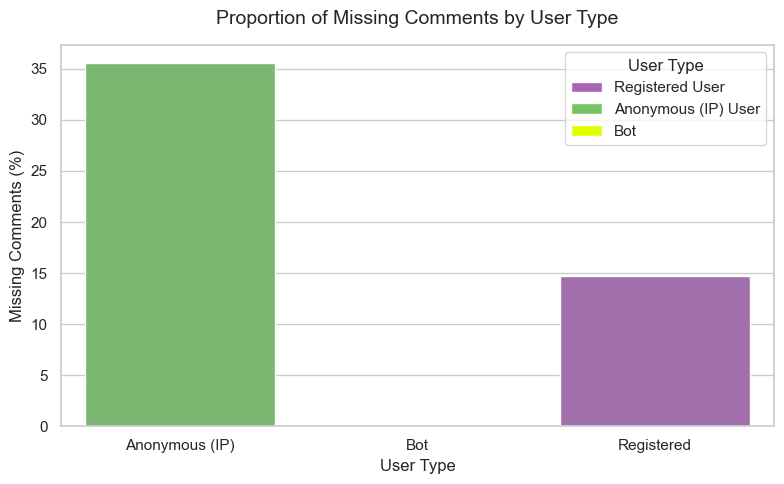

In [8]:
def plot_missing_comment_per_user_type(dataframe, wanna_save=False):

    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby("user_type")
        .size()
        .reset_index(name="missing_count")
    )
    
    total = (
        dataframe.groupby("user_type")
        .size()
        .reset_index(name="total_count")
    )
    comparison = missing.merge(total, on="user_type", how="right").fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]
    
    custom_palette = {
        "Registered": "#a865b5",      
        "Anonymous (IP)": "#74c365", 
        "Bot": "#dfff00"
    }
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    
    sns.barplot(
        data=comparison,
        x="user_type",
        y="missing_percentage",
        hue='user_type',
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#a865b5", label="Registered User"),
        Patch(facecolor="#74c365", label="Anonymous (IP) User"),
        Patch(facecolor="#dfff00", label="Bot")
    ]
    plt.legend(
        handles=legend_elements,
        title="User Type",
        loc="upper right",
        frameon=True
    )
    fig_title = "Proportion of Missing Comments by User Type"
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches="tight")
        
    plt.show()

plot_missing_comment_per_user_type(df_preprocessed, False)

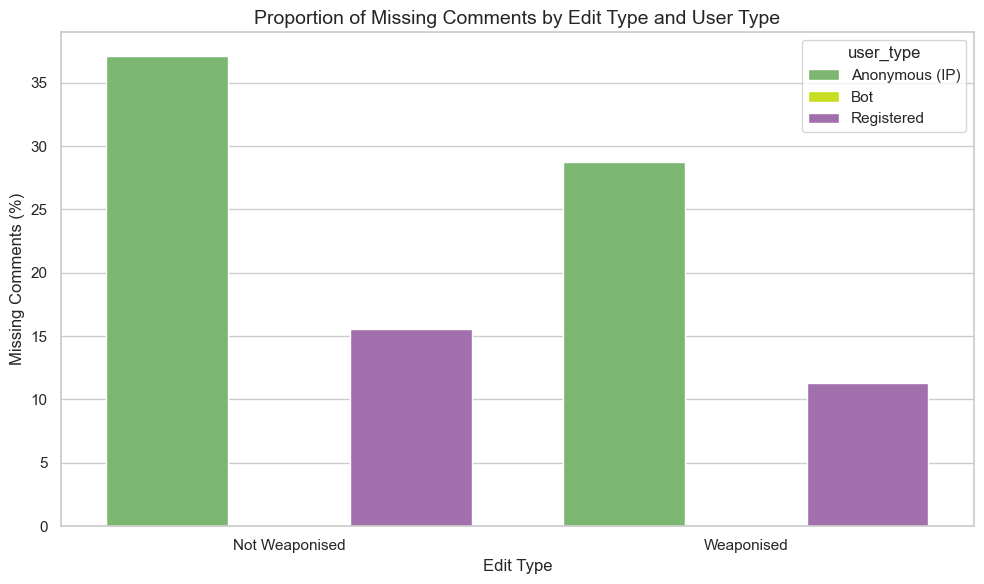

In [9]:
def plot_missing_comment_user_type_edit_type(dataframe, wanna_save=False):
    
    custom_palette = {
        "Registered": "#a865b5",
        "Anonymous (IP)": "#74c365",
        "Bot": "#dfff00"
    }
    
    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="missing_count")
    )
    
    # Total edits per edit type
    total = (
        dataframe.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="total_count")
    )
    
    # Merge & compute proportions
    comparison = total.merge(missing, on=["user_type", "weaponised"], how="left")
    comparison["missing_count"] = comparison["missing_count"].fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        data=comparison,
        x="weaponised",
        y="missing_percentage",
        hue="user_type",
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by Edit Type and User Type", fontsize=14)
    plt.xlabel("Edit Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    
    fig_title = "Proportion of Missing Comments by Edit Type and User Type"
    if wanna_save:
        plt.savefig(f"../../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_missing_comment_user_type_edit_type(df_preprocessed, False)

In [27]:
missing = (
    df_preprocessed[df_preprocessed["comment"].isna()]
    .groupby(["user_type", 'weaponised'])
    .size()
    .reset_index(name="missing_count")
)

missing.pivot(columns='weaponised', index='user_type', values='missing_count')

weaponised,Not Weaponised,Weaponised
user_type,,
Anonymous (IP),5394,945
Registered,6161,1090


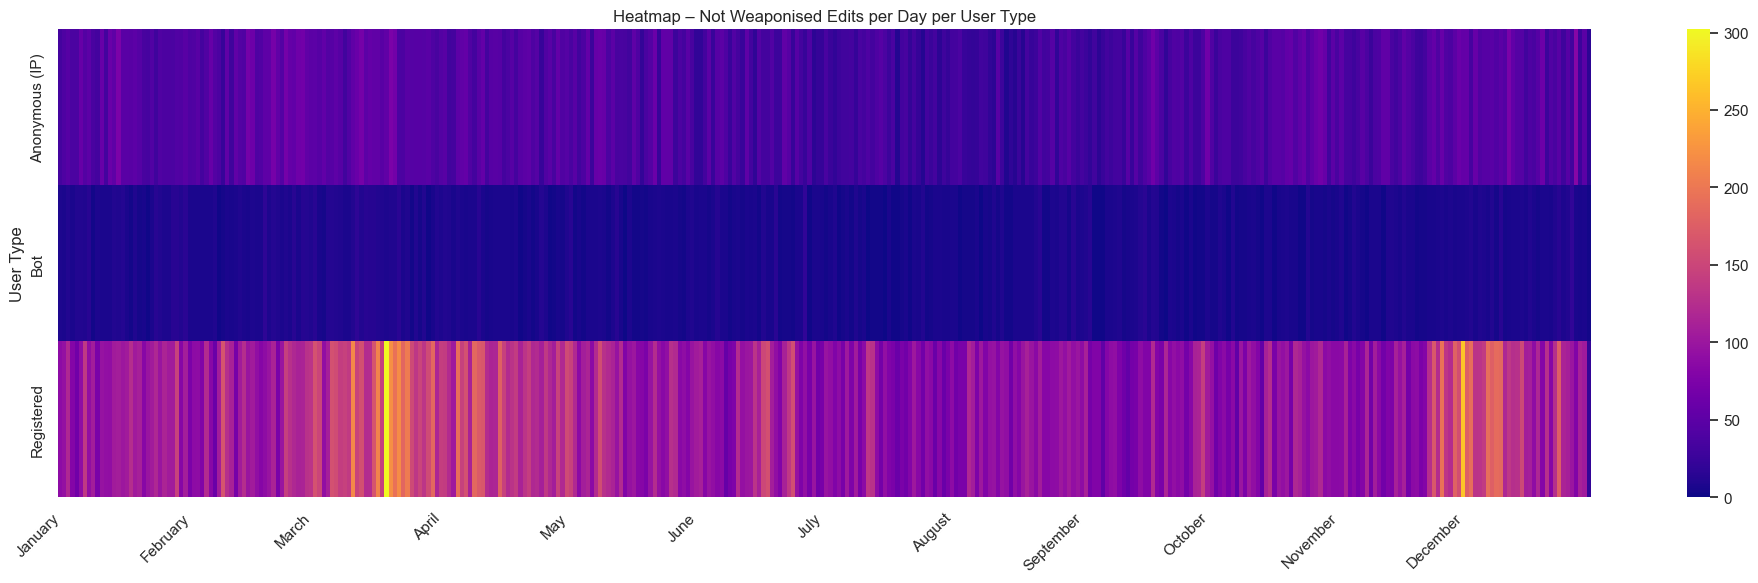

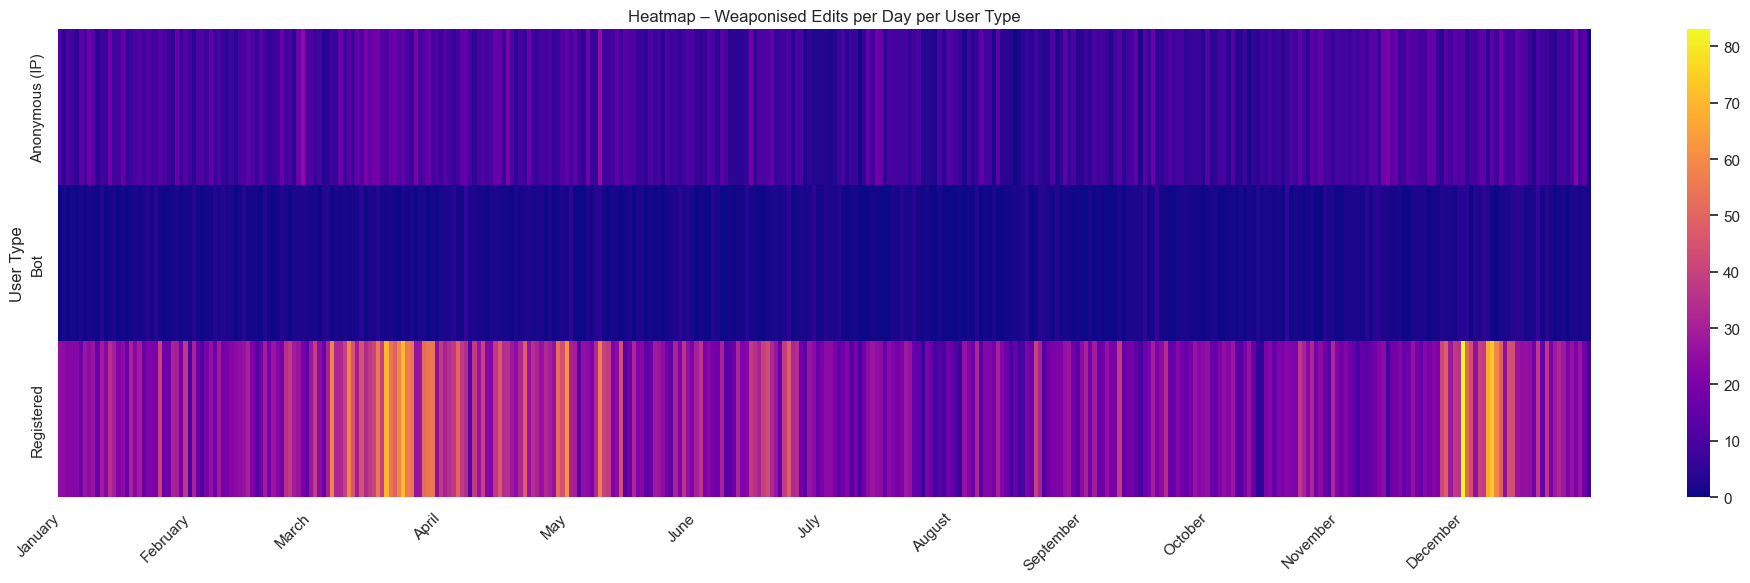

In [143]:
def plot_heatmaps(dataframe, wanna_save=False):

    dataframe = dataframe.copy()
    dt = pd.to_datetime(df["date"], errors="coerce")
    dataframe["date"] = dt.dt.date
    dataframe["doy"] = dt.dt.dayofyear
    
    df_not_weap = dataframe[dataframe["weaponised"] == "Not Weaponised"].copy()
    df_weap     = dataframe[dataframe["weaponised"] != "Not Weaponised"].copy()

    daily_not_weap = (
        df_not_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )


    daily_not_weap["doy"] = pd.to_datetime(daily_not_weap["date"]).dt.dayofyear
    daily_weap["doy"]     = pd.to_datetime(daily_weap["date"]).dt.dayofyear


    hm_not_weap = daily_not_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    
    hm_not_weap = hm_not_weap.reindex(columns=range(1, 367), fill_value=0)
    hm_weap     = hm_weap.reindex(columns=range(1, 367), fill_value=0)

    
    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_not_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Not_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    return hm_not_weap, hm_weap

hm_not, hm_weap = plot_heatmaps(df_preprocessed)